El lavado de dinero es un desafío significativo en el sector financiero, y la detección temprana es clave para prevenir actividades fraudulentas. Este proyecto utiliza un conjunto de datos de transacciones financieras para identificar patrones asociados con el lavado de dinero.



*   Análisis Exploratorio: Realizar un análisis inicial de las transacciones para detectar patrones y posibles indicadores de lavado de dinero.
*   Aprendizaje Automático: Desarrollar un modelo supervisado de clasificación que identifique transacciones sospechosas.
*   Evaluación: Evaluar el rendimiento del modelo para validar su eficacia en la detección de transacciones anómalas.

Este proyecto tiene el potencial de ser una herramienta valiosa para las empresas fintech que buscan mejorar sus sistemas de seguridad y detectar fraudes.



# Inicialización del entorno

En esta sección se descargar las librerías necesarias para el código del proyecto y se carga en memoria el dataset utilizado.

El primer paso es descargar las librerías necesarias.

In [1]:
modules = ["pandas", "numpy", "matplotlib", "seaborn", "scipy", "tqdm"]

import sys
import os.path
from subprocess import check_call
import importlib
import os

def instala(modules):
    print("Instalando módulos")
    for m in modules:
        # para el import quitamos [...] y ==...
        p = m.find("[")
        mi = m if p==-1 else m[:p]
        p = mi.find("==")
        mi = mi if p==-1 else mi[:p]
        torch_loader = importlib.util.find_spec(mi)
        if torch_loader is not None:
            print(m," encontrado")
        else:
            print(m," No encontrado, instalando...",end="")
            try:
                r = check_call([sys.executable, "-m", "pip", "install", "--user", m])
                print("¡hecho!")
            except:
                print("¡Problema al instalar ",m,"! ¿seguro que el módulo existe?",sep="")

    print("¡Terminado!")

instala(modules)

Instalando módulos
pandas  encontrado
numpy  encontrado
matplotlib  encontrado
seaborn  encontrado
scipy  encontrado
tqdm  encontrado
¡Terminado!


A continuación, necesitamos leer los datos de entrada como un Pandas dataframe.

Se utiliza el dataset de la dirección de Kaggle:
https://www.kaggle.com/datasets/ealaxi/paysim1


Este dataset generado sintéticamente con el simulador PaySim modela transacciones móviles con un enfoque en la detección de fraudes. Incluye varios tipos de transacciones (CASH-IN, CASH-OUT, TRANSFER, etc.) y muestra variables como el saldo antes y después de la transacción, la cantidad, y si se considera fraudulenta. Esta simulación usa datos reales anonimizados de un mes de registros financieros.


In [5]:
import pandas as pd

# Configura pandas para mostrar números decimales en vez de notación científica
pd.options.display.float_format = '{:.2f}'.format

df = pd.read_csv('data/Synthetic_Financial_Dataset_For_Fraud_Detection.csv')

# Análisis exploratorio

En esta sección, exploramos el dataset para comprender mejor sus características y patrones subyacentes, lo cual es esencial antes de aplicar modelos de *machine learning*. Aquí realizaremos cálculos de estadísticas descriptivas (medias, medianas, desviaciones estándar) y visualizaremos los datos con gráficos como histogramas y boxplots. Además, identificaremos outliers y diferencias de medias entre grupos, utilizando técnicas como el bootstrapping. Este análisis ayuda a identificar posibles problemas, patrones importantes y relaciones entre variables, proporcionando una base sólida para las etapas de modelado posterior.

Comencemos haciendo un análisis preeliminar para obtener algo de información de las diferentes columnas y sus valores:

In [7]:
# Visualizar las columnas del dataset
print("Columnas en el dataset:")
print(df.columns)

# Obtener información general del dataset, como el tipo de datos y la cantidad de valores no nulos
print("\nInformación del dataset:")
df.info()

# Calcular estadísticas descriptivas de columnas numéricas
print("\nEstadísticas descriptivas de columnas numéricas:")
print(df.describe())

# Calcular el reparto de transacciones legales y fraudulentas
print("\Reparto de transacciones legales y fraudulentas:")
print(df['isFraud'].value_counts())


Columnas en el dataset:
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132654 entries, 0 to 1132653
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1132654 non-null  int64  
 1   type            1132654 non-null  object 
 2   amount          1132654 non-null  float64
 3   nameOrig        1132654 non-null  object 
 4   oldbalanceOrg   1132654 non-null  float64
 5   newbalanceOrig  1132654 non-null  float64
 6   nameDest        1132654 non-null  object 
 7   oldbalanceDest  1132654 non-null  float64
 8   newbalanceDest  1132653 non-null  float64
 9   isFraud         1132653 non-null  float64
 10  isFlaggedFraud  1132653 non-null  float64
dtypes: float64(7), int64(1), ob

The first column, Step, maps ever unit to an hour in real time. Since the .5 percentile shows 23, we can determine that the majority of transactions are performed within a day.

El promedio de transacción es de aproximadamente 160,515, pero existe una gran dispersión, puesto que la desviación estándar es de 273,981. Además, los valores mínimo y máximo de 0.10 y 10000000, respectivamente, hacen indicar que el dataset se podría beneficiar de un filtrado de outliers.

Finalmente, podemos ver que el número de transacciones legales es mucho mayor al de las transacciones fraudulentas, puestas estas últimas apenas representan un 0,13% del total.

Para entender mejor el reparto de transacciones se puede consultas el diagrama de frecuencias a continuación:

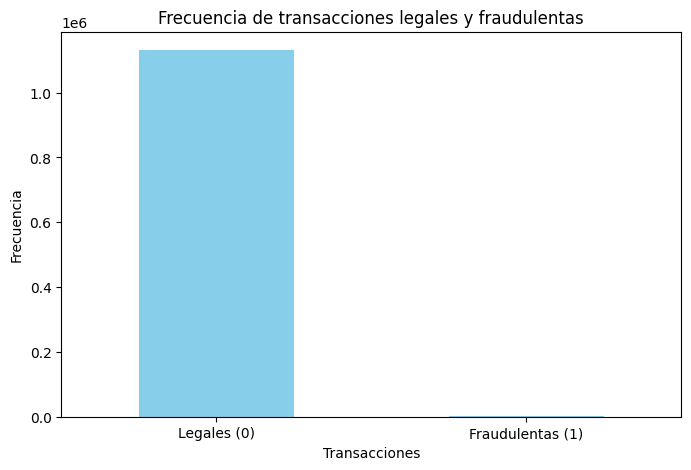

In [12]:
import matplotlib.pyplot as plt

frecuencias = df['isFraud'].value_counts().sort_index()

# Crear un diagrama de barras usando pandas
frecuencias.plot(kind='bar', figsize=(8, 5), color='skyblue', title='Frecuencia de transacciones legales y fraudulentas')
plt.xlabel('Transacciones')
# Cambiar la etiqueta 0 por Legales y la 1 por Fraudulentas
plt.xticks([0, 1], ['Legales', 'Fraudulentas'], rotation=0)
plt.ylabel('Frecuencia')
plt.show()

Como se puede ver, la frecuencia de transacciones fraudulentas resulta apenas visible comparada con la frecuencia de transacciones legales.

Los diagramas de frecuencia son sumamente útiles para entender la distribución de los datos. Por ejemplo, también lo podríamos usar para ver que tipos de transferencias existen a partir de la columna type:

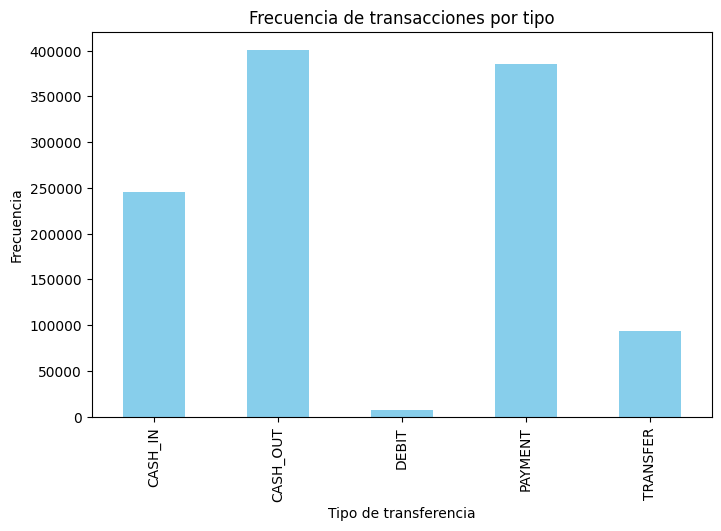

In [11]:
frecuencias = df['type'].value_counts().sort_index()

# Crear un diagrama de barras usando pandas
frecuencias.plot(kind='bar', figsize=(8, 5), color='skyblue', title='Frecuencia de transacciones por tipo')
plt.xlabel('Tipo de transferencia')
plt.ylabel('Frecuencia')
plt.show()

Para enriquecer el análisis por tipo de transferencia, podemos analizar las medias de sus valores:

In [13]:
df.groupby('type')[['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']].mean()


,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
type,,,,
CASH_IN,3753165.60,3923666.53,1454317.72,1378972.05
CASH_OUT,56610.37,25643.85,1385097.38,1638061.86
DEBIT,80310.88,76695.76,1277026.64,1339708.03
PAYMENT,95423.98,89390.32,0.00,0.00
TRANSFER,63311.26,13586.28,1991549.20,2731658.45
